In [1]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

from itertools import chain
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from tqdm.auto import tqdm

## additional_funcs

In [20]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
  model.train()
  epoch_loss = []
  for (local_batch, local_label) in train_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    optimizer.zero_grad()
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    curr_loss.backward()
    optimizer.step()
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
  model.eval()
  epoch_loss = []
  for (local_batch, local_label) in val_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
  model.eval()
  test_hits = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  for (local_batch, local_label) in test_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    _, preds = torch.max(y_pred, 1)
    _, local_label =  torch.max(local_label, 1)
    test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
    total += torch.numel(preds.view(-1))
    for t, p in zip(local_label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix, test_hits, total

In [3]:
class EarlyStopping():
  def __init__(self, min_delta=0.001, tolerance=20):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.flag = False
    self.min_loss = 1000

  def __call__(self, val_loss):
    if (val_loss - self.min_loss) > self.min_delta:
      self.counter += 1
      if self.counter >= self.tolerance:
        self.flag = True
    self.min_loss = val_loss if val_loss < self.min_loss else self.min_loss

## 1. Представление и предобработка текстовых данных

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [51]:
text = 'Select your preferences and run the install command! Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [4]:
def preprocess_text(text: str):
    text = re.sub(r"[^a-zA-Z.,!?]", " ", text).lower()
    return text

In [55]:
preprocess_text(text)

'select your preferences and run the install command! stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c  '

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [5]:
def create_binlist(text: str):
    sentences = nltk.tokenize.sent_tokenize(text)
    tokens = list(chain.from_iterable([nltk.word_tokenize(re.sub(r'[^a-zA-Z ]', "",sentence)) for sentence in sentences]))
    binlist = []
    for token in tokens:
        if token not in binlist:
            binlist.append(token)
    return binlist

In [6]:
def to_tensor(bin_list: list, sentence: str):
    sentence = list(nltk.tokenize.word_tokenize(sentence))
    return [1 if word in sentence else 0 for word in bin_list]

In [ ]:
binlist = create_binlist(preprocess_text(text))
print(binlist)

['select', 'your', 'preferences', 'and', 'run', 'the', 'install', 'command', 'stable', 'represents', 'most', 'currently', 'tested', 'supported', 'version', 'of', 'pytorch', 'note', 'that', 'libtorch', 'is', 'only', 'available', 'for', 'c']


In [ ]:
sent = re.sub(r"[^a-zA-Z ]", "", nltk.sent_tokenize(text)[1]).lower()

In [ ]:
to_tensor(binlist, sent)

[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

### Датасет

In [ ]:
class Vocab:
    def __init__(self, data:list): # data - list of tokens
        self.create_binlist(data)

        self.idx_to_token = {i: v for i,v in enumerate(self.binlist)}
        self.token_to_idx = {v: i for i,v in enumerate(self.binlist)}
        self.vocab_len = len(self.binlist)

    def create_binlist(self, data):
        self.binlist = []
        for token in data:
            if token not in self.binlist:
                self.binlist.append(token)

    def __len__(self):
        return self.vocab_len

In [94]:
class SurnamesDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.load_df(path)
        self.preprocess_df()
        self.sur_vocab = Vocab(list(chain.from_iterable([[x for x in word] for word in self.df['surname'].tolist()])))
        self.nat_vocab = Vocab(self.df['nationality'].tolist())

        self.X = self.df['surname'].tolist()
        self.y = self.df['nationality'].tolist()



    def preprocess_df(self):
        self.df['surname'] = self.df['surname'].str.lower()
        self.df['nationality'] = self.df['nationality'].str.lower()

    def load_df(self, path):
        self.df = pd.read_csv(path)

    def vectorize(self, sample, type):
        binlist = self.sur_vocab.binlist if type == 0 else self.nat_vocab.binlist
        sample = [x for x in sample] if type == 0 else sample
        return torch.tensor([1 if token in sample else 0 for token in binlist], dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx], 0), self.vectorize(self.y[idx], 1)

### Модель

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=input_size*2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=input_size*2, out_features=input_size*4),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=input_size*4, out_features=input_size*2),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.classificator = nn.Sequential(
            nn.Linear(in_features=input_size*2, out_features=output_size),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.linear.forward(x)
        x = self.classificator.forward(x)
        return x

#### init

In [ ]:
BATCH_SIZE = 200
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [95]:
dataset = SurnamesDataset(r'C:\Users\user\Desktop\dz\DL\lab5\data\surnames.csv')

In [ ]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [ ]:
model = Model(len(dataset.sur_vocab), len(dataset.nat_vocab)).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 56888


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.01, tolerance=10)

#### model processing

In [ ]:
train_loss = []
val_loss = []
for epoch in range(EPOCH):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'early stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


early stop at epoch №40


<Axes: >

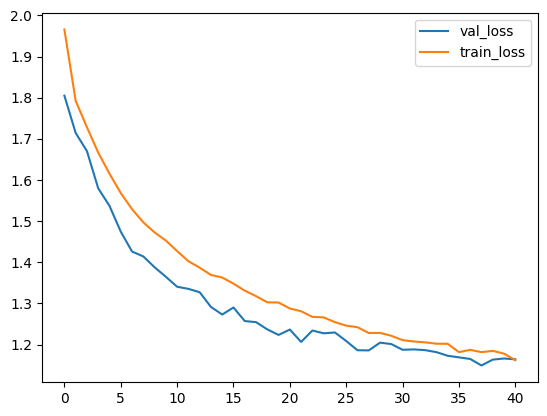

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataset.nat_vocab)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 66.3%


<Axes: >

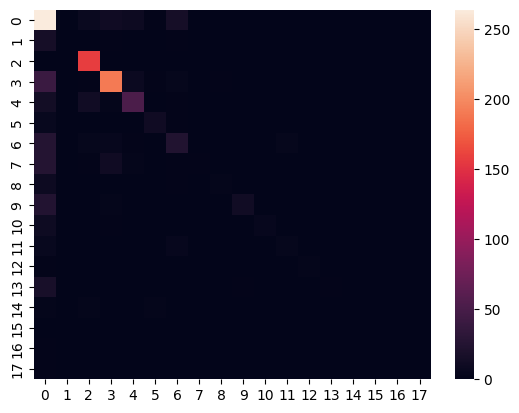

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

In [ ]:
students = ['Alueva', 'Sultonov', 'Mikhailenko']
students = [dataset.vectorize(x.lower(), 0) for x in students]
students = torch.stack(students).to(device)

preds = model.forward(students)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
_, preds = torch.max(preds, 1)
preds

tensor([3, 3, 3], device='cuda:0')

In [ ]:
nat_list = [dataset.nat_vocab.idx_to_token[x] for x in preds.cpu().tolist()]
nat_list

['russian', 'russian', 'russian']

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


### Датасет

In [4]:
# Мной принято решение, что использовать векторизацию, данную в 1ом задании для 2го просто около бессмысленно, а для 3го еще и слишком ресурсозатрано
# Потому архитектуру датасета и модели оставляю за собой 

In [4]:
def normalize_text(text: str):

    stemmer = SnowballStemmer('english')
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    text = re.sub(r"[^a-zA-Z.,!?]", " ", text).lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [5]:
class Vocab:
    def __init__(self, data:list, start=0, num_words=5000): # data - list of tokens
        self.create_count_dict(data)
        self.token_to_count = dict(sorted(self.token_to_count.items(), key = lambda x: x[1], reverse=True)[0:num_words])

        self.idx_to_token = {i+start: v for i,v in enumerate(self.token_to_count.keys())}
        self.token_to_idx = {v: i+start for i,v in enumerate(self.token_to_count.keys())}
        self.vocab_len = len(self.token_to_count.keys())

    def create_count_dict(self, data):
        self.token_to_count = {}
        for token in data:
            if token not in self.token_to_count.keys():
                self.token_to_count[token] = 1
            else:
                self.token_to_count[token] += 1

    def __len__(self):
        return self.vocab_len

In [6]:
class ReviewDataset(Dataset):
    def __init__(self, path, topwords_num = 5000):
        self.load_df(path)
        self.preprocess_df()

        self.score_vocab = Vocab(self.df['score'].tolist(), num_words=2)
        self.review_vocab = Vocab(list(chain.from_iterable([[x for x in seq] for seq in self.df['review'].tolist()])), start=1, num_words = topwords_num)

        self.X = self.df['review'].tolist()
        self.y = self.df['score'].tolist()

        self.rev_max_len = len(max(self.df['review'], key=len))

    def load_df(self, path):
        self.df = pd.read_csv(path, delimiter=",", header=None, names=['score', 'review'], skiprows=lambda x: x%10 != 0)

    def preprocess_df(self):
        self.df['review'] = self.df['review'].apply(normalize_text)

    def vectorize(self, sample, type):
        vocab = self.review_vocab if type == 0 else self.score_vocab
        sample = [sample] if type == 1 else sample
        if type == 0:
            sample = [vocab.token_to_idx.get(token, 0) for token in sample]
            if (len(sample) <= self.rev_max_len):
                zeros = list(np.zeros(self.rev_max_len - len(sample)).astype(int))
                sample = zeros + sample
            else:
                sample = sample[: self.rev_max_len]
            return torch.tensor(sample)
        else:
            return torch.tensor([1 if token in sample else 0 for token in vocab.token_to_count.keys()], dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx], 0), self.vectorize(self.y[idx], 1)

In [7]:
path = r'C:\Users\user\Desktop\dz\DL\lab5\data\raw_train.csv'

In [8]:
dataset = ReviewDataset(path, topwords_num = 3000)

In [23]:
BATCH_SIZE = 2000
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [24]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [25]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

### Модель

In [13]:
class sshape(torch.nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [14]:
class Transpose(torch.nn.Module):
    def __init__(self, dim0, dim1):
        super(Transpose, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1
        
    def forward(self, x):
        x = torch.transpose(x, self.dim0, self.dim1)
        return x

In [15]:
class GetFeaturesFromRNN(torch.nn.Module):
    def forward(self, x):
        x, _ = x
        if len(x.shape) == 3:
            return x[:, -1, :]
        elif len(x.shape) == 2:
            return x[:, -1]

In [16]:
class Model(torch.nn.Module):
    def __init__(self, input_size, output_size): #input_size - len of rev dict
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Embedding(input_size+1, embedding_dim=200, padding_idx=0),
            nn.Dropout(0.25),
            Transpose(dim0=1, dim1=2),
            nn.Conv1d(in_channels=200, out_channels=50, kernel_size=3, stride=1, padding=0, dilation=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool1d(2),
            Transpose(dim0=1, dim1=2),
            nn.LSTM(50, 200, num_layers=3, batch_first=True, dropout=0.5),
            GetFeaturesFromRNN()
        )
        self.classificator = nn.Sequential(
            nn.Linear(in_features=200, out_features=output_size),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.features.forward(x)
        x = torch.flatten(x, 1)
        x = self.classificator.forward(x)
        return x

In [26]:
in_size = len(dataset.review_vocab.token_to_count.keys())
out_size = len(dataset.score_vocab)

In [27]:
model = Model(in_size, out_size).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 1475452


In [28]:
next(model.parameters()).is_cuda

True

In [29]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.01, tolerance=10)

#### model processing

In [30]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
    epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
    train_loss.append(epoch_train_loss)
    
    with torch.no_grad():
        epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
        val_loss.append(epoch_val_loss)
    
    early_stopping(epoch_val_loss)
    if early_stopping.flag:
        print(f'early stop at epoch №{epoch}')
        break
torch.cuda.empty_cache() if device == 'cuda' else None

early stop at epoch №37


<Axes: >

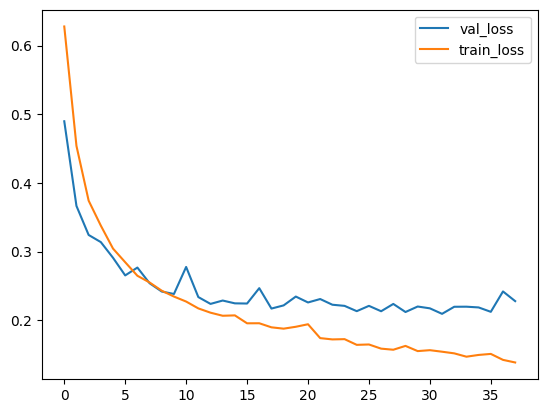

In [31]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [33]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataset.review_vocab)
torch.cuda.empty_cache() if device == 'cuda' else None

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [34]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 91.29%


In [41]:
rev = [
    "Ordered a large Mango-Pineapple smoothie. Stayed in line 5 minutes from the time I ordered. Which was okay, I made sure I started out 10 minutes early for the trip. $3.64 for a large. Got to the window stayed an additional 3 minutes. No big deal. Until...... Ma'am We no have Mango. We have Um.. Strawberry. Reluctantly I said Ok... It's just Strawberry right? Not Strawberry-Banana? Si Strawberry- Banana. Side note...( I don't like Strawberry- Banana) No ma'am I would just like my money back... refund please... she gave me $3.53 back? Wasted my time and made a profit! Geez!!",
    "The best fast food Hamburger ever!!!! This In-N-Out on the west side is great."  
      ]
rev = [normalize_text(x) for x in rev]
vec = torch.stack([dataset.vectorize(x, 0) for x in rev]).to(device)

preds = model.forward(vec)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [44]:
_, preds = torch.max(preds, 1)
preds

tensor([0, 1], device='cuda:0')